In [4]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

In [2]:
u_inf = 1.0             # free-stream speed

## Geometry

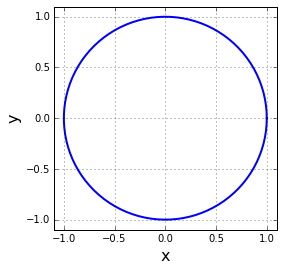

In [3]:
# defines the cylinder
R = 1.0                                                     # radius
theta = numpy.linspace(0, 2*math.pi, 100)                           # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder

# plots the cylinder
%matplotlib inline

size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

## Set the panels

In [4]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [5]:
N_panels = 10                    # number of panels desired

# defining the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# defining the panels
panels = numpy.empty(N_panels, dtype=object)
for i in xrange(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

## Solve linear sys for Panel Strength

In [6]:
def integral_normal(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
		return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., p_j.length)[0]

In [7]:
# computes the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# computes the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

In [8]:
# solves the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
	panel.sigma = sigma[i]

In [11]:
print sum(sigma)

-1.33226762955e-15


### Solve for velocity Field

In [15]:
# define the domain
# define the domain
N = 100                               # Number of points in each direction
x_start, x_end = -5.0, 5.0            # x-direction boundaries
y_start, y_end = -3., 3.            # y-direction boundaries
x = numpy.linspace(x_start, x_end, N)    # computes a 1D-array for x
y = numpy.linspace(y_start, y_end, N)    # computes a 1D-array for y
X, Y = numpy.meshgrid(x, y)              # generates a mesh grid

In [26]:
def sum_integral_vel(panels, x, y):
    """Given a point, calculate the velocity induced by panels
    """
    u = 0.
    v = 0.
    for panel in panels:
        def func_x(s):
            return 2*(x-(panel.xa-numpy.sin(panel.beta)*s)) / \
                    ((x-(panel.xa-numpy.sin(panel.beta)*s))**2 +\
                     (y-(panel.ya+numpy.cos(panel.beta)*s))) 
        def func_y(s):
            return 2*(y-(panel.ya+numpy.cos(panel.beta)*s)) / \
                    ((x-(panel.xa-numpy.sin(panel.beta)*s))**2 +\
                     (y-(panel.ya+numpy.cos(panel.beta)*s)))         
        u += panel.sigma/(4*numpy.pi) * integrate.quad(lambda s:func_x(s), 0, panel.length)[0]
        #v += panel.sigma/(4*numpy.pi) * integrate.quad(lambda s:func_y(s), 0, panel.length)[0]
    return u, v

In [7]:
?integrate

In [28]:
U = numpy.zeros_like(X)
V = numpy.zeros_like(X)
# x index
for i in range(N):
    for j in range(N):
        x,y = X[i,j], Y[i,j]
        u,v = sum_integral_vel(panels, x, y)
        U[i,j], V[i,j] = u,v

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Python/2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  warnings.warn(msg, IntegrationWarning)


In [13]:
def distance(a,b):
    """Return the distance bwt two points.
    
    Arguments:
        a, b: sdf
    
    Return:
        distance
    """
    return numpy.sqrt(a**2-b**2)

In [14]:
?distance